In [10]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import cv2
import os 
import keras
from keras import layers, models
from tensorflow import keras as tfkeras
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm 

In [26]:
image_size = 128
batch_size = 64
learn_rate = 0.01
epochs = 50
data_dir = "/kaggle/input/plantvillage-dataset/color"
input_folder = "/kaggle/input/plant-disease-test/test_images"
test_images = os.listdir("/kaggle/input/plant-disease-test/test_images")

In [60]:
def read_img(image_data):
    try:
        image = cv2.imread(image_data)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize the image
        image = image.reshape(1, image_size, image_size, 3)
        
        return image

    except Exception as e:
        print(f"Error> {e}")

In [13]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size,
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size,
)

Found 54305 files belonging to 38 classes.
Using 48875 files for training.
Found 54305 files belonging to 38 classes.
Using 5430 files for validation.


In [14]:
lencoder = LabelEncoder()

disease_classes = train_data.class_names

enc_classes = lencoder.fit_transform(disease_classes)

encoded_disease_classes = lencoder.classes_

print(encoded_disease_classes)
enc_classes

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=AUTOTUNE)

optimizer = keras.optimizers.Adam(learning_rate=learn_rate)

early_stop = keras.callbacks.EarlyStopping(
    min_delta=0.001, patience=10, restore_best_weights=True
)

In [33]:
data_augmentation = keras.models.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(image_size,
                                  image_size,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
disease_clf = models.Sequential(
    [
        layers.Rescaling(1.0 / 255, input_shape=(image_size, image_size, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.1),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(38, activation="softmax")
    ]
)

# disease_clf.compile(
#     optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

disease_clf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


disease_clf.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_10 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,766 (8.11 MB)

 Trainable params: 2,125,766 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

In [65]:
%%time

history = disease_clf.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
#   callbacks=[early_stop]
)

Epoch 1/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.5690 - loss: 1.5557 - val_accuracy: 0.8230 - val_loss: 0.5662
Epoch 2/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 24s 16ms/step - accuracy: 0.8035 - loss: 0.6709 - val_accuracy: 0.7974 - val_loss: 0.7335
Epoch 3/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8438 - loss: 0.5621 - val_accuracy: 0.8357 - val_loss: 0.6644
Epoch 4/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8579 - loss: 0.5490 - val_accuracy: 0.8501 - val_loss: 0.6906
Epoch 5/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8817 - loss: 0.4702 - val_accuracy: 0.8405 - val_loss: 0.8883
Epoch 6/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.8795 - loss: 0.5104 - val_accuracy: 0.8643 - val_loss: 0.7744
Epoch 7/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8919 - loss: 0.5072 - val_accuracy: 0.8372 - val_loss: 1.0911
Epoch 8/30
1528/1528 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.8835 -

In [66]:
test_accuracy = disease_clf.evaluate(val_data, batch_size=32)

print(
    f"The trained plant leaf disease detection model has an accuracy of {100*test_accuracy[1]}%"
)

170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8314 - loss: 0.5416
The trained plant leaf disease detection model has an accuracy of 82.30202794075012%


In [67]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

ValueError: x and y must have same first dimension, but have shapes (30,) and (10,)

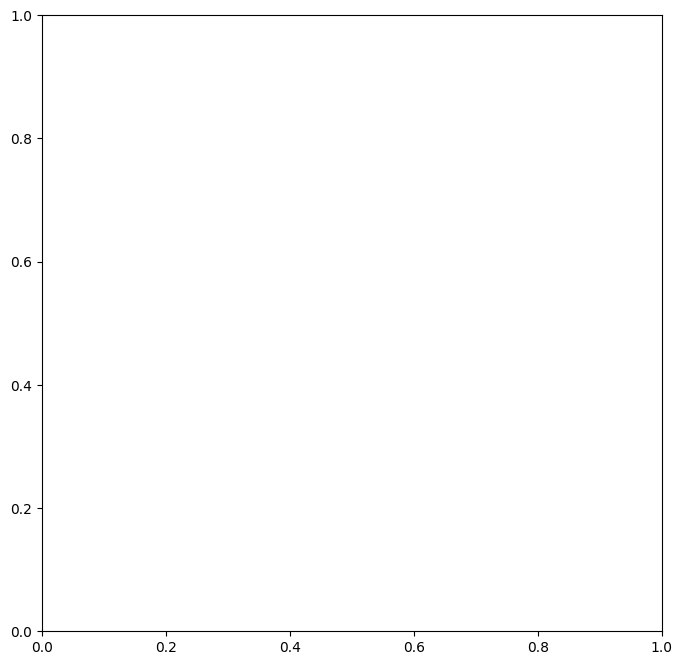

In [68]:
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="upper right")
plt.title("Training and Validation Accuracy")

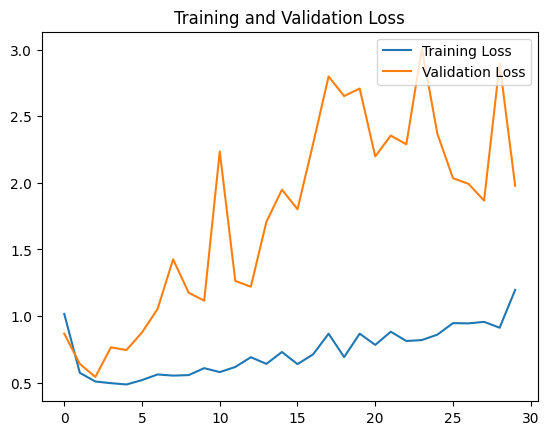

In [58]:
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [63]:
image_list = [os.path.join(input_folder, image_file) for image_file in test_images]

def detect_plant_disease(image: str):
    image = read_img(image)
    class_score = disease_clf.predict(image)
    
    predicted_class = class_score.argmax()
    certainty = 100 * class_score.max()
    
    return predicted_class, certainty
    
    
for image in tqdm(image_list):
    disease_class, certainty = detect_plant_disease(image)
    print(' ')
    print('________________')
    print(f'Input Sentence: {image}')
    print(f'Predicted: {encoded_disease_classes[disease_class]}')
    print(f'Certainty: {certainty:.2f}%')

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/apple_healthy.jpeg
Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Certainty: 99.81%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
 
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/healthy_tomato_leaf.jpeg
Predicted: Tomato___Tomato_Yellow_Leaf_Curl_Virus
Certainty: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
 
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/cornleafnormal.jpeg
Predicted: Tomato___Late_blight
Certainty: 98.37%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/tomato_leafdiseas.jpeg
Predicted: Tomato___Late_blight
Certainty: 98.81%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 
________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/leafrustcorn.jpeg
Predicted: Corn_(maize)___Northern_Leaf_Blight
Certainty: 64.04%
1/1

In [ ]:
disease_clf.save("tf_plant_disease_classifier.keras")
disease_clf.save("tf_plant_disease_classifier.h5")